# 모델 저장과 복원
---
- 방법1) 모델 전체 저장(모델구조 + 가중치 + 변수)
    * save_model()
    * 복원시 추가 작업 필요 없이 모델 파일 로딩해서 사용 가능
- 방법2) 가중치만 저장
    * save_weights()
    * 복원시 모델 구조(Architecture) 생성 후 가중치 적용
- 방법3) 모델 전체 또는 가중치 자동 저장
    * fit()에서 ModelCheckPoint Event에 대한 callback 등록
    * save_best_only=True : 모니터링 기준에 따라서 좋은 성능의 모델만 저장
    * save_weights_only=True : 가중치만 저장
- 파일 또는 폴더
    * 파일 확장자가 없으면 폴더로 저장
    * 파일 확장자
        - h5 / hdf5 : HDF5 포맷으로 모델 또는 가중치 저장
        - ckpf : 체크파일형태로 저장
        - pd : 모델 저장

## [1] 데이터 준비

In [69]:
from sklearn.datasets import load_iris
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import set_random_seed, plot_model
import numpy as np

## [1] 데이터 준비 및 로딩
---

In [70]:
iris=load_iris()

In [71]:
x_train=iris.data
y_train=iris.target

print(f'x_train.shape : {x_train.shape}, y_train.shape : {y_train.shape}')

x_train.shape : (150, 4), y_train.shape : (150,)


In [72]:
iris.target_names, iris.feature_names

(array(['setosa', 'versicolor', 'virginica'], dtype='<U10'),
 ['sepal length (cm)',
  'sepal width (cm)',
  'petal length (cm)',
  'petal width (cm)'])

In [73]:
# Feature => 꽃잎의 길이, 너비
x_train=x_train[:, 2:]
x_train.shape

(150, 2)

In [74]:
# Target => 문자 => 수치화
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [75]:
lencoder = LabelEncoder()
y_train=lencoder.fit(y_train).transform(y_train)

In [76]:
ohencoder=OneHotEncoder()
y_train=ohencoder.fit(y_train.reshape(-1,1)).transform(y_train.reshape(-1,1))

In [77]:
y_train=y_train.toarray()

In [78]:
x_train.shape, y_train.shape, y_train[0]

((150, 2), (150, 3), array([1., 0., 0.]))

In [79]:
from sklearn.preprocessing import StandardScaler

In [80]:
scaler=StandardScaler()

In [81]:
x_scaled_train=scaler.fit(x_train).transform(x_train)

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_train,
                                                    y_train,
                                                    stratify=y_train)

In [84]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train)

In [85]:
print(f'x_train.shape : {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')
print(f'x_val.shape : {x_val.shape}')

x_train.shape : (84, 2)
x_test.shape : (38, 2)
x_val.shape : (28, 2)


## [3] 모델 구성 및 생성
---
- 입력 데이터 : 2개 Feature
- 출력 데이터 : 3개 품종
- 학습 방법 : 분류 - 다중분류

In [86]:
# W,b 초기값 고정
set_random_seed(15)

In [87]:
irisModel=Sequential(name='irisModel')

In [88]:
irisModel.add(Dense(9, activation='relu', input_shape=(2,)))

In [89]:
irisModel.add(Dense(3, activation='softmax'))

In [90]:
irisModel.summary()

Model: "irisModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 27        
                                                                 
 dense_1 (Dense)             (None, 3)                 30        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


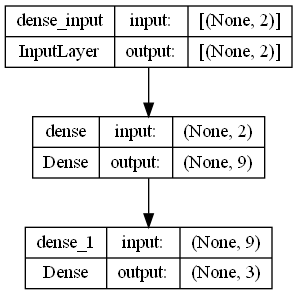

In [91]:
plot_model(irisModel, show_shapes=True)

In [92]:
## 모델 생성
irisModel.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics='accuracy')

## [4] 모델 학습

In [93]:
irisModel.fit(x_train, y_train, epochs=1000, verbose=False)

In [94]:
## [5] 평가
lossv, accv=irisModel.evaluate(x_test, y_test)

2/2 [==============================] - 1s 17ms/step - loss: 0.1284 - accuracy: 0.9211


## [6] 모델 저장

In [95]:
from tensorflow.keras.models import save_model

In [96]:
M_FILE='irisModel.h5'
W_FILE='irisWeight.h5'

In [97]:
if accv>=0.97:
    save_model(irisModel, M_FILE)
    irisModel.save_weights(W_FILE)

## [7] 복원
---
- 모델 또는 가중치 복원
- load_model(모델 파일 또는 모델 폴더명)
- Sequential.load_weights(가중치 파일 또는 폴더명)

### [7-1] 모델 복원

In [98]:
from tensorflow.keras.models import load_model

In [99]:
reModel=load_model(M_FILE)

In [100]:
reModel.evaluate(x_test, y_test)

2/2 [==============================] - 1s 5ms/step - loss: 0.1189 - accuracy: 0.9211


[0.11889485269784927, 0.9210526347160339]

In [101]:
reModel.summary()

Model: "irisModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 9)                 27        
                                                                 
 dense_25 (Dense)            (None, 3)                 30        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


### [7-2] 가중치 복원
---
- 모델 구조 생성
- 가중치 로딩

In [102]:
# 모델 구조 구성
newModel=Sequential(name='newirisModel')
newModel.add(Dense(9, activation='relu', input_shape=(2,)))
newModel.add(Dense(3, activation='softmax'))
newModel.summary()

Model: "newirisModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 9)                 27        
                                                                 
 dense_3 (Dense)             (None, 3)                 30        
                                                                 
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [103]:
# 모델 생성
newModel.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics='accuracy')

In [104]:
# 가중치 로딩
newModel.load_weights(W_FILE)

In [105]:
newModel.evaluate(x_test, y_test)

2/2 [==============================] - 1s 6ms/step - loss: 0.1189 - accuracy: 0.9211


[0.11889485269784927, 0.9210526347160339]

# AutoEncode 노이즈 제거
---
- 데이터에 노이즈 제거 활용
- 데이터에서 주요 특징만 추출 압축하기 때문에 노이즈는 주요 특징에서 제거
- 압축된 주요 특징으로 데이터 복원 => 노이즈 제거

In [106]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt

## [1] 데이터 준비 및 로딩

In [107]:
(x_train, y_train), (x_test, y_test) = load_data()

In [108]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

## [2] 데이터 전처리

In [109]:
x_train=x_train.reshape(-1, 28*28)/255.0

In [110]:
x_train[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
x_test=x_test.reshape(-1, 28*28)/255.0

In [112]:
x_test[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [113]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [114]:
# 데이터셋에서 노이즈 추가
# np.random.normal(평균loc=0.0, 표준편차scale=1.0, 출력size=None)
x_train_noised = x_train + np.random.normal(0, 0.5, size=x_train.shape)
x_test_noised = x_test + np.random.normal(0, 0.5, size=x_test.shape)

# 픽셀 범위 0.0~1.0 벗어나는 픽셀값 조정 np.clip(array, min, max)
x_train_noised = np.clip(x_train_noised, a_min=0, a_max=1)
x_test_noised = np.clip(x_test_noised, a_min=0, a_max=1)

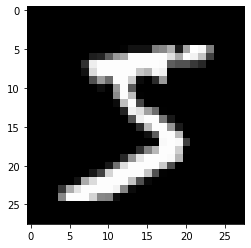

In [115]:
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
plt.show()

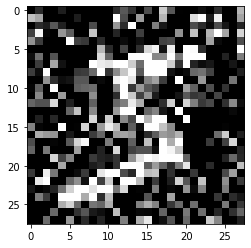

In [116]:
plt.imshow(x_train_noised[0].reshape(28,28), cmap='gray')
plt.show()

## [3] 모델 구성 및 생성

In [117]:
# W,b 초기값 고정
set_random_seed(11)

In [118]:
def createAEModel(n_node):
    model=Sequential()
    # 입력
    model.add(Dense(units=n_node, activation='relu', input_shape=(784,)))
    # 출력
    model.add(Dense(784, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [119]:
oneModel=createAEModel(1)
tenModel=createAEModel(10)
thirtyModel=createAEModel(30)
fiftyModel=createAEModel(50)

In [120]:
oneModel.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 785       
                                                                 
 dense_5 (Dense)             (None, 784)               1568      
                                                                 
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


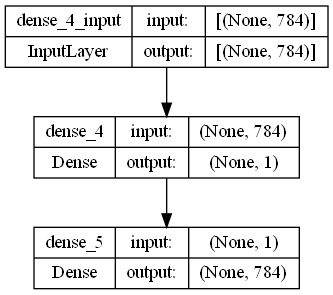

In [121]:
plot_model(oneModel, show_shapes=True)

## [4] 모델 학습

In [122]:
oneModel.fit(x_train_noised, x_train, epochs=30, verbose=0)
tenModel.fit(x_train_noised, x_train, epochs=30, verbose=0)
thirtyModel.fit(x_train_noised, x_train, epochs=30, verbose=0)
fiftyModel.fit(x_train_noised, x_train, epochs=30, verbose=0)

In [123]:
x_train_noised.shape

(60000, 784)

In [124]:
oneModel.evaluate(x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 27.1216


27.12156867980957

## [5] 예측
---
- 새로운 데이터 사용

In [125]:
pre_out1=oneModel.predict(x_test_noised[0].reshape(-1,784))
pre_out10=tenModel.predict(x_test_noised[0].reshape(-1,784))
pre_out30=thirtyModel.predict(x_test_noised[0].reshape(-1,784))
pre_out50=fiftyModel.predict(x_test_noised[0].reshape(-1,784))

1/1 [==============================] - 0s 101ms/step


In [126]:
 x_test[0].shape, pre_out1[0].shape

((784,), (784,))

### 원본 이미지 - AE 진행된 이미지 비교

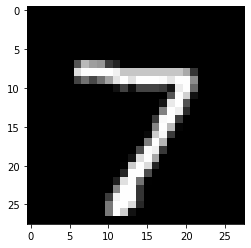

In [127]:
plt.imshow(x_test[0].reshape(28,28), cmap='gray')
plt.show()

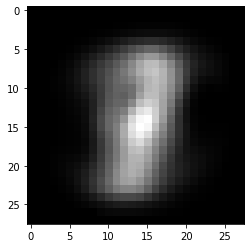

In [128]:
plt.imshow(pre_out1[0].reshape(28,28), cmap='gray')
plt.show()

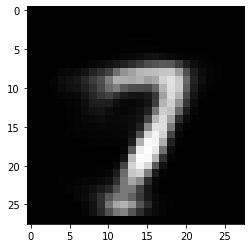

In [129]:
plt.imshow(pre_out10[0].reshape(28,28), cmap='gray')
plt.show()

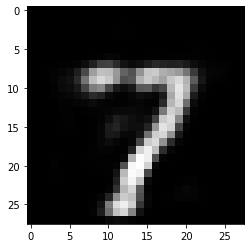

In [130]:
plt.imshow(pre_out30[0].reshape(28,28), cmap='gray')
plt.show()

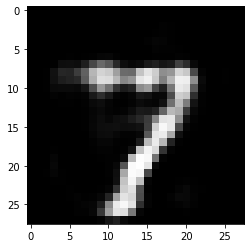

In [131]:
plt.imshow(pre_out50[0].reshape(28,28), cmap='gray')
plt.show()

# AutoEncode
---
- 표현(특징) 학습
    * 데이터에서 주요 특징을 찾아 압축 후 복원하는 학습 모델
- 구성
    * 인코더(Encoder) : 입력 데이터에서 주요 특징 추출 / 압축
    * 디코더(Decoder) : 주요 특징에서 원 데이터로 복원

In [132]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## [1] 데이터 준비 및 로딩

In [133]:
(x_train, y_train), (x_test, y_test) = load_data()

In [134]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

## [2] 데이터 전처리

In [135]:
x_train=x_train.reshape(-1, 28*28)/255.0

In [136]:
x_train[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [137]:
x_test=x_test.reshape(-1, 28*28)/255.0

In [138]:
x_test[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [139]:
print(x_train.shape, x_test.shape)

(60000, 784) (10000, 784)


In [140]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train,
                                                    random_state=12,
                                                    stratify=y_train)

In [141]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                  random_state=12,
                                                  stratify=y_train)

In [142]:
print(x_train.shape, x_test.shape, x_val.shape)

(33750, 784) (15000, 784) (11250, 784)


## [3] 모델 구성 및 생성
- 퍼셉트론 개수 조절 노드수 조절할 수 있도록 모델 생성 함수 만들기

In [143]:
# W, b 초기값 고정
set_random_seed(11)

In [144]:
def createAEModel(n_node):
    model=Sequential()
    # 입력
    model.add(Dense(units=n_node, activation='relu', input_shape=(784,)))
    # 출력
    model.add(Dense(784, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [145]:
oneModel=createAEModel(1)
fiveModel=createAEModel(5)
tenFiveModel=createAEModel(15)
hundModel=createAEModel(100)

In [146]:
oneModel.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 785       
                                                                 
 dense_13 (Dense)            (None, 784)               1568      
                                                                 
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


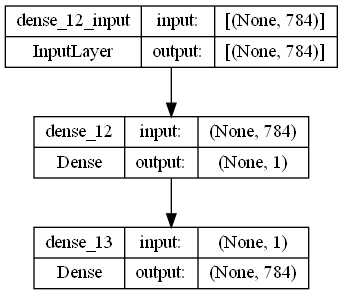

In [147]:
plot_model(oneModel, show_shapes=True)

## [4] 모델 학습

In [148]:
# x 값 모두 입력 데이터
oneModel.fit(x_train, x_train, epochs=10, verbose=0)
fiveModel.fit(x_train, x_train, epochs=10, verbose=0)
tenFiveModel.fit(x_train, x_train, epochs=10, verbose=0)
hundModel.fit(x_train, x_train, epochs=10, verbose=0)

In [149]:
oneModel.evaluate(x_test, x_test)

469/469 [==============================] - 1s 3ms/step - loss: 0.0629


0.0628964975476265

## [5] 예측
---
- 새로운 데이터 사용

In [150]:
pre_out1=oneModel.predict(x_val[0].reshape(-1,784))
pre_out5=fiveModel.predict(x_val[0].reshape(-1,784))
pre_out15=tenFiveModel.predict(x_val[0].reshape(-1,784))
pre_out100=hundModel.predict(x_val[0].reshape(-1,784))

1/1 [==============================] - 0s 106ms/step


In [151]:
x_val[0].shape, pre_out1.shape

((784,), (1, 784))

### 원본 이미지 - AE 진행된 이미지 비교
- auto encoder

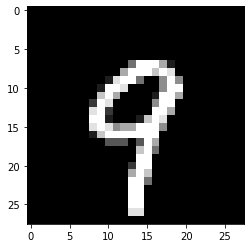

In [152]:
plt.imshow(x_val[0].reshape(28,28), cmap='gray')
plt.show()

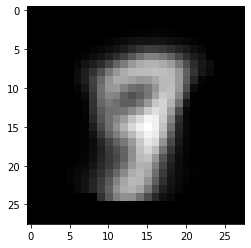

In [153]:
plt.imshow(pre_out1.reshape(28,28), cmap='gray')
plt.show()

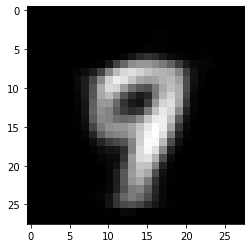

In [154]:
plt.imshow(pre_out5.reshape(28,28), cmap='gray')
plt.show()

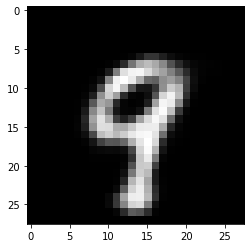

In [155]:
plt.imshow(pre_out15.reshape(28,28), cmap='gray')
plt.show()

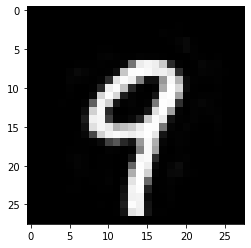

In [156]:
plt.imshow(pre_out100.reshape(28,28), cmap='gray')
plt.show()

# CNN(Convolution Neural Network)
---
- 이미지, 영상 처리에 사용되는 신경망 모델
- DNN의 한 분야
- 텍스트 처리에도 사용되는 모델
- 사용되는 Layer
    * ConvXD : 이미지의 형태 그대로 입력 받아 특징을 추출하는 레이어
    * Pooling : 특징맵에서 특징을 다시 추출, 다운샘플링하는 레이어, 크기 반으로 줄임

In [157]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
import numpy as np
import matplotlib.pyplot as plt

In [158]:
# W,b 고정하도록 seed 설정
set_random_seed(11)

## [1] 데이터 준비 및 로딩
---

In [159]:
(x_train, y_train), (x_test, y_test) = load_data()

In [160]:
print(f'x_train.shape : {x_train.shape}, y_train.shape : {y_train.shape}')
print(f'x_test.shape : {x_test.shape}, y_test.shape : {y_test.shape}')

x_train.shape : (60000, 28, 28), y_train.shape : (60000,)
x_test.shape : (10000, 28, 28), y_test.shape : (10000,)


## [2] 데이터 전처리 및 학습형태로 변환

In [161]:
# 스케일링 => 픽셀 / 255.0
x_train=x_train/255.0
x_test=x_test/255.0

In [162]:
# Conv 레이어는 이미지 채널 정보까지 입력
x_train=x_train.reshape(-1, 28, 28, 1)
x_test=x_test.reshape(-1, 28, 28, 1)

In [163]:
print(f'x_train.shape : {x_train.shape}, x_test.shape : {x_test.shape}')

x_train.shape : (60000, 28, 28, 1), x_test.shape : (10000, 28, 28, 1)


In [164]:
# 테이터셋에 노이즈 추가
# np.random.normal(평균loc=0.0, 표준편차scale=1.0, 출력size=None)
x_train_noised = x_train + np.random.normal(0, 0.5, size=x_train.shape)
x_test_noised = x_test + np.random.normal(0, 0.5, size=x_test.shape)

# 픽셀 범위 0.0~1.0 벗어나는 픽셀값 조정 np.clip(array, min, max)
x_train_noised = np.clip(x_train_noised, a_min=0, a_max=1)
x_test_noised = np.clip(x_test_noised, a_min=0, a_max=1)

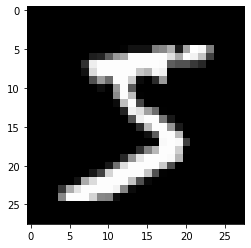

In [165]:
plt.imshow(x_train[0].reshape(28,28), cmap='gray')
plt.show()

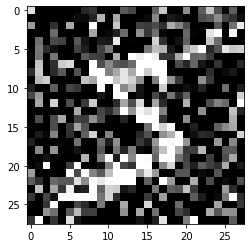

In [166]:
plt.imshow(x_train_noised[0].reshape(28,28), cmap='gray')
plt.show()

## [3] 모델 구성 및 생성
---
- 입력 형태 : 채널정보까지 포함 3차원 (28, 28, 1)
- 출력 형태 : 0 ~ 9 정수 확률값 10개 출력
- 학습 방식  분류 - 이진분류
- 전반부
    * 이미지 특징 추출
        - Conv2D
- 후반부
    * 이미지 데이터 학습
        - Conv2D

### [3-1] 모델 구상 및 생성
---
- compile 메서드
    * loss 손실 함수 => binary_crossentropy
    * optimizer 최적화 방식 => adam

In [167]:
def createCNNModel(n_kernel):
    model=Sequential()
    # 이미지 특징 추출 Layer => 첫번째 입력값 설정
    model.add(Conv2D(n_kernel, kernel_size=3, padding='same', input_shape=(28,28,1)))
    # 출력
    model.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                 optimizer='adam')
    return model

In [168]:
oneModel=createCNNModel(1)
fiveModel=createCNNModel(5)
tenFiveModel=createCNNModel(15)

In [169]:
oneModel.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 28, 28, 1)         10        
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 1)         10        
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


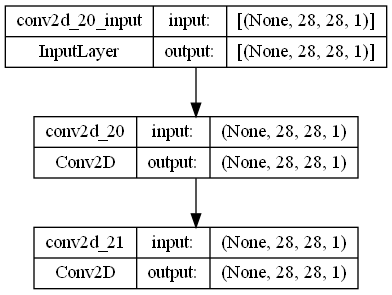

In [170]:
plot_model(oneModel, show_shapes=True)

### [3-2] 모델 학습
---
- fit 메서드
    * 학습 데이터, 라벨
    * epochs 학습횟수
    * batch_size 학습분량
    * validation_data (검증데이터, 검증라벨)
    * validation_split 학습데이터의 일부 비율 설정 (예:0.2)
    * callback
    * verbose : 학습 진행도 화면 출력 여부 설정

In [171]:
oneModel.fit(x_train_noised, x_train, epochs=10)
fiveModel.fit(x_train_noised, x_train, epochs=10)
tenFiveModel.fit(x_train_noised, x_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 27s 13ms/step - loss: 0.2589
Epoch 2/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1226
Epoch 3/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1217
Epoch 4/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1210
Epoch 5/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1207
Epoch 6/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1205
Epoch 7/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1204
Epoch 8/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.1204
Epoch 9/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1203
Epoch 10/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1203
Epoch 1/10
1875/1875 [==============================] - 33s 17ms/step - loss: 0.1680
Epoch 2/10
1875/1875 [==============================] - 32s 17ms

In [172]:
x_train_noised.shape

(60000, 28, 28, 1)

## [4] 평가
---
- evaluate 메서드
- 테스트 데이터, 테스트 라벨

In [173]:
oneModel.evaluate(x_test, x_test)

313/313 [==============================] - 3s 8ms/step - loss: 0.0802


0.08023250102996826

## [5] 예측
---
- 새로운 데이터 사용

In [174]:
x_test_noised[0].shape

(28, 28, 1)

In [175]:
pre_out1=oneModel.predict(x_test_noised[0])
pre_out5=fiveModel.predict(x_test_noised[0])
pre_out15=tenFiveModel.predict(x_test_noised[0])

1/1 [==============================] - 0s 115ms/step


In [176]:
x_test[0].shape

(28, 28, 1)

### 원본 이미지 - AE 진행된 이미지 비교

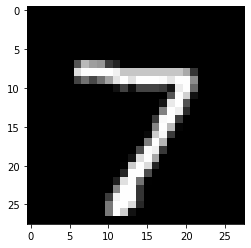

In [177]:
plt.imshow(x_test[0].reshape(28,28), cmap='gray')
plt.show()

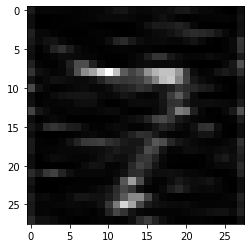

In [178]:
plt.imshow(pre_out1.reshape(28,28), cmap='gray')
plt.show()

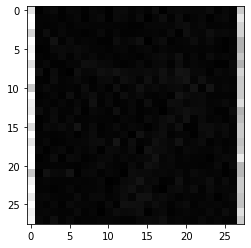

In [179]:
plt.imshow(pre_out5.reshape(28,28), cmap='gray')
plt.show()

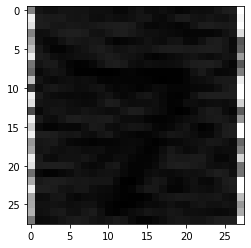

In [180]:
plt.imshow(pre_out15.reshape(28,28), cmap='gray')
plt.show()